In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

Begin by importing financial data, formating it to integers and calculating proting and return rate

In [2]:

df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
df["production_budget"] = df["production_budget"].str.replace(",","").str.replace("$","").astype(int)
df["domestic_gross"] = df["domestic_gross"].str.replace(",","").str.replace("$","").astype(int)
df["worldwide_gross"] = df["worldwide_gross"].str.replace(",","").str.replace("$","").astype(int)
df['profit'] = df['worldwide_gross'] - df['production_budget']
df['return_rate'] = df['profit']/df['production_budget']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   int64  
 4   domestic_gross     5782 non-null   int64  
 5   worldwide_gross    5782 non-null   int64  
 6   profit             5782 non-null   int64  
 7   return_rate        5782 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 361.5+ KB


<ipython-input-2-09543b13dc95>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["production_budget"] = df["production_budget"].str.replace(",","").str.replace("$","").astype(int)
<ipython-input-2-09543b13dc95>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["domestic_gross"] = df["domestic_gross"].str.replace(",","").str.replace("$","").astype(int)
<ipython-input-2-09543b13dc95>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["worldwide_gross"] = df["worldwide_gross"].str.replace(",","").str.replace("$","").astyp

Since financial ad director data come from different sources need to use movie name to switch between the sources

In [3]:
title_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz',compression = 'gzip')
title_basics = title_basics.drop(['start_year','runtime_minutes','genres'], axis = 1)
title_basics.head()

,tconst,primary_title,original_title
0,tt0063540,Sunghursh,Sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante


In [4]:
title_basics = title_basics.set_index('primary_title')
title_basics.head()

,tconst,original_title
primary_title,,
Sunghursh,tt0063540,Sunghursh
One Day Before the Rainy Season,tt0066787,Ashad Ka Ek Din
The Other Side of the Wind,tt0069049,The Other Side of the Wind
Sabse Bada Sukh,tt0069204,Sabse Bada Sukh
The Wandering Soap Opera,tt0100275,La Telenovela Errante


In [5]:
def get_tconst(primary_title):
    if primary_title in title_basics.index:
        return title_basics['tconst'][primary_title];
    else:
        return np.NaN;
    


df['tconst'] = df['movie'].apply(get_tconst)

In [6]:
df = df.dropna(subset=['tconst'])
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2376 entries, 0 to 5780
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2376 non-null   int64  
 1   release_date       2376 non-null   object 
 2   movie              2376 non-null   object 
 3   production_budget  2376 non-null   int64  
 4   domestic_gross     2376 non-null   int64  
 5   worldwide_gross    2376 non-null   int64  
 6   profit             2376 non-null   int64  
 7   return_rate        2376 non-null   float64
 8   tconst             2376 non-null   object 
dtypes: float64(1), int64(5), object(3)
memory usage: 185.6+ KB


With movie's ID now obtained next is to use the movie Id to get the directors ID

In [7]:
title_crew = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz',compression = 'gzip')
title_crew = title_crew.dropna(subset = ['directors'])
title_crew = title_crew.set_index('tconst')
title_crew.head()

,directors,writers
tconst,,
tt0285252,nm0899854,nm0899854
tt0462036,nm1940585,nm1940585
tt0835418,nm0151540,"nm0310087,nm0841532"
tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943
tt0879859,nm2416460,NaN


In [8]:
valid_tconst = title_crew.index.to_list();
def get_nconst(t_value):
    check = t_value
    if type(t_value) == str:   
        if check in valid_tconst:
            return title_crew['directors'][t_value];
        else:
            return np.NaN;
    else:
        return np.NaN

df['nconst'] = df['tconst'].apply(get_nconst)
df = df.dropna(subset = ['nconst'])

With director ID get directors name

In [9]:
personal_data = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz',compression = 'gzip')
personal_data = personal_data.set_index('nconst')
personal_data.head()
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606648 entries, nm0061671 to nm9993380
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   primary_name        606648 non-null  object 
 1   birth_year          82736 non-null   float64
 2   death_year          6783 non-null    float64
 3   primary_profession  555308 non-null  object 
 4   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(3)
memory usage: 27.8+ MB


In [10]:
valid_nconst = personal_data.index.to_list();
def name(nconst):
    if type(nconst) == str:   
        if nconst in valid_nconst:
            return personal_data['primary_name'][nconst];
        else:
            return np.NaN;
    else:
        return np.NaN
 
df['name'] = df['nconst'].apply(name)
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,return_rate,tconst,nconst,name
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577,tt1775309,nm3786927,Atsushi Wada
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,tt1298650,nm0551128,Rob Marshall
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,tt6565702,nm1334526,Simon Kinberg
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,tt2395427,nm0923736,Joss Whedon
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,5.827114,tt4154756,"nm0751577,nm0751648",NaN


In [11]:
df['nconst'] = df['nconst'].str.split(',').tolist()
df.head()
df = df.explode('nconst')
df = df.dropna(subset = ['nconst'])

With Director name and financial data obtained on a single data frame the next step is to create a graph comparing the two.

In [12]:

#data falsely attributed avatar to wrong director
df = df.drop([0])

In [13]:
directors_group = df.groupby(by = 'name').mean()

In [14]:
directors_group = directors_group.sort_values(by= 'profit',ascending = False)
directors_group_top_profit = directors_group.head(20)

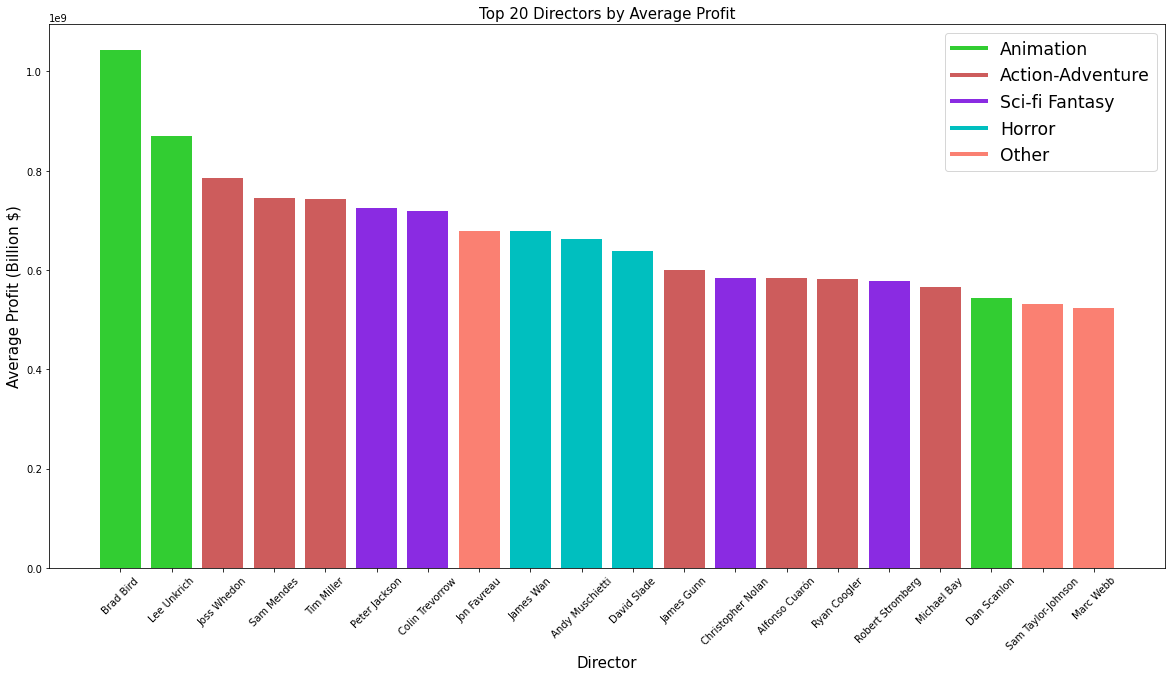

In [22]:
# Plot a bar graph of the most common names 
fig, ax = plt.subplots(figsize = (20,10))

color_index = ['limegreen','limegreen','indianred','indianred',
               'indianred','blueviolet','blueviolet','salmon','c','c','c',
               'indianred','blueviolet','indianred','indianred','blueviolet',
               'indianred','limegreen','salmon','salmon']
ax.bar(directors_group_top_profit.index, directors_group_top_profit['profit'],color = color_index)

# Add labels for x and y axes
ax.set_xlabel('Director', fontsize = 15)
ax.set_ylabel('Average Profit (Billion $)', fontsize = 15)

#setting color
custom_lines = [Line2D([0], [0], color="limegreen", lw=4),
                Line2D([0], [0], color="indianred", lw=4),
                Line2D([0], [0], color="blueviolet", lw=4),
                Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color ="salmon",lw=4)]

# Add a title for the plot
ax.set_title('Top 20 Directors by Average Profit', fontsize=15)

ax.tick_params(axis='x', labelrotation = 45)

# add a legend 
plt.legend(custom_lines, ['Animation', 'Action-Adventure', 'Sci-fi Fantasy','Horror', 'Other'], fontsize="xx-large")

###
fig.savefig('Top_20_directors.pdf')

Switch to directors avg profit by rating, using costum data set created in other notebook

In [20]:
df = pd.read_csv('data/zippedData/Final_data.csv.gz',compression='gzip')

In [21]:
#format string 'known_ratings' to list
def to_int(in_string):
    out = []
    hold_string = in_string;
    try:
        if len(hold_string) == 2:
            return np.NaN
        elif len(hold_string) == 7:
            int_val = in_string[2:5];
            out.append(float(int_val));
        elif len(hold_string) == 14:
            int_val = in_string[2:5];
            out.append (float(int_val));
            int_val_2 = in_string[9:12]
            out.append (float(int_val_2));
        elif len(hold_string) == 21:
            int_val = in_string[2:5];
            out.append (float(int_val));
            int_val_2 = in_string[9:12]
            out.append (float(int_val_2));
            int_val_3 = in_string[16:19];
            out.append(float(int_val_3));
        else:
            int_val = in_string[2:5];
            out.append (float(int_val));
            int_val_2 = in_string[9:12]
            out.append (float(int_val_2));
            int_val_3 = in_string[16:19];
            out.append (float(int_val_3));
            int_val_4 = in_string[23:26];
            out.append(float(int_val_4))
        return out;
    except:
        return np.NaN;
df['known_ratings'] = df['known_ratings'].apply(to_int)

In [22]:
#calculate ratings statistics
def get_avg(in_list):
    return np.average(in_list);

def get_max(in_list):
    return np.amax(in_list);

def get_min(in_list):
    return np.amin(in_list);

df['rate_avg'] = df['known_ratings'].apply(get_avg)
df['rate_max'] = df['known_ratings'].apply(get_max)
df['rate_min'] = df['known_ratings'].apply(get_min)

In [23]:
#group by director
df_grouped = df.groupby(by=['nconst']).mean()
df_grouped.head()

,id,production_budget,domestic_gross,worldwide_gross,profit,return_rate,rate_avg,rate_max,rate_min
nconst,,,,,,,,,
nm0000095,58.333333,1.816667e+07,17779013.0,7.049560e+07,5.232893e+07,2.819199,7.925,8.0,7.9
nm0000108,90.000000,1.800000e+08,40479370.0,2.150984e+08,3.509836e+07,0.194991,7.475,8.5,6.4
nm0000110,87.333333,8.833333e+07,111478193.0,3.088756e+08,2.205423e+08,2.824880,7.250,7.7,6.5
nm0000123,45.000000,4.650000e+07,59497077.0,1.182193e+08,7.171934e+07,1.823502,6.950,7.4,6.1
nm0000127,61.500000,3.250000e+07,26462681.5,5.635853e+07,2.385853e+07,0.534419,6.925,7.5,6.4


In [21]:
#create regression
ax = sns.regplot(x='rate_avg', y = 'profit',data=df_grouped)
ax.set_title('Avg Ratings vs Avg Profit by Director')
fig = ax.get_figure()
fig.savefig('Profit_by_Ratings.pdf')

NameError: name 'df_grouped' is not defined